In [1]:
from crowdkit.aggregation import DawidSkene, MajorityVote
from crowdkit.datasets import load_dataset
import pandas as pd
df, gt = load_dataset('relevance-2')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [3]:
df

,worker,task,label
0,w851,t30685,1
1,w6991,t30008,0
2,w2596,t36316,0
3,w5507,t15145,1
4,w2982,t44785,1
...,...,...,...
475531,w4660,t62250,1
475532,w6630,t46626,0
475533,w4605,t93513,1
475534,w1928,t29002,0


In [4]:
gt

task
t30006    0
t33578    0
t22462    1
t52093    0
t26935    0
         ..
t57345    1
t81052    1
t7189     1
t80463    0
t93643    0
Name: true_label, Length: 10079, dtype: int64

Text(0, 0.5, 'Number of annotators')

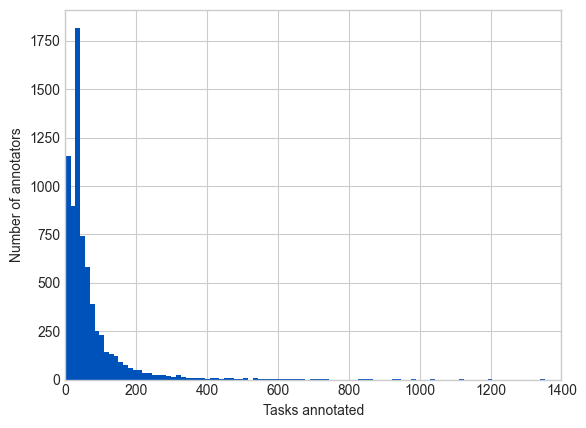

In [59]:
# See distribution of how many tasks every worker annotated
counts = df['worker'].value_counts().to_list()

fig = plt.figure()
ax = plt.axes()
ax.hist(counts, bins=100, color="#0052bb")
ax.set_xlim(0, 1400)
#ax.set_xticks(np.arange(0,101,10), minor=False)
ax.set_xlabel("Tasks annotated")
ax.set_ylabel("Number of annotators")

# plt.savefig("distribution of annotations", dpi=100, bbox_inches='tight')

In [7]:
ds = DawidSkene(n_iter=100)
ds_result = ds.fit_predict(df)
ds_result

task
t30685    1
t30008    0
t36316    0
t15145    1
t44785    0
         ..
t95222    0
t83525    0
t49227    0
t96106    1
t16185    1
Name: agg_label, Length: 99319, dtype: int64

In [8]:
mv = MajorityVote()
mv_result = mv.fit_predict(df)
mv_result

task
t0       1
t1       1
t10      1
t100     0
t1000    0
        ..
t9995    1
t9996    0
t9997    0
t9998    0
t9999    1
Name: agg_label, Length: 99319, dtype: int64

In [9]:
from sklearn.metrics import f1_score, accuracy_score

In [10]:
f1_score(gt, mv_result[gt.index])

0.7621861152141802

In [11]:
f1_score(gt, ds_result[gt.index])

0.7878520154610712

## Confusion matrices
The workers' error matrices. "label" column is the annotation, "0" and "1" columns are the "true" values (according to the model).

In [12]:
errors_ds = ds.errors_
errors_ds

,,0,1
worker,label,,
w851,1,1.000000e+00,1.000000e+00
w6991,0,8.737855e-01,2.129593e-01
w2596,0,8.033569e-01,1.475727e-04
w5507,1,2.296647e-01,8.646991e-01
w2982,1,1.725128e-01,7.786426e-01
...,...,...,...
w6117,0,1.983403e-01,1.481812e-11
w3477,0,1.978918e-01,1.408250e-02
w6387,0,4.433634e-04,5.823680e-02


In [13]:
errors_ds.keys()

Index([0, 1], dtype='object')

In [14]:
errors_ds.loc["w2596"]

,0,1
label,,
0,0.803357,0.000148
1,0.196643,0.999852


In [15]:
errors_ds.loc["w2580"]

,0,1
label,,
0,9.999998e-01,0.562048
1,2.489844e-07,0.437952


## Accuracies

In [16]:
worker_ids = set([tup[0] for tup in errors_ds.index])
accuracies = dict.fromkeys(worker_ids, 0)

for w_id in worker_ids:
    # wrong = errors_ds.loc[w_id][0][1] + errors_ds.loc[w_id][1][0]
    if 0 in errors_ds.loc[w_id][0].keys():
        TN = errors_ds.loc[w_id][0][0]
    else:
        TN = 0
    if 1 in errors_ds.loc[w_id][1].keys():
        TP = errors_ds.loc[w_id][1][1]
    else:
        TP = 0

    accuracy = round((TP + TN) / 2 * 100, 2)
    accuracies[w_id] = accuracy
    
    #print("worker id:", w_id)
    #print(errors_ds.loc[w_id])
    #print("this person is correct {}% of the time".format(accuracy))

In [17]:
# dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=False))
accs = sorted(accuracies.values())
print(accs[:30])
print()
print(accs[-30:])

[0.0, 0.0, 0.03, 0.89, 1.08, 2.35, 8.68, 9.0, 9.07, 9.62, 9.83, 10.24, 10.51, 12.01, 12.59, 13.59, 15.07, 15.65, 16.8, 18.08, 18.37, 18.64, 18.71, 19.5, 20.7, 20.95, 21.05, 21.51, 22.3, 22.36]

[99.98, 99.99, 99.99, 99.99, 99.99, 99.99, 99.99, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


Text(0, 0.5, 'Number of annotators')

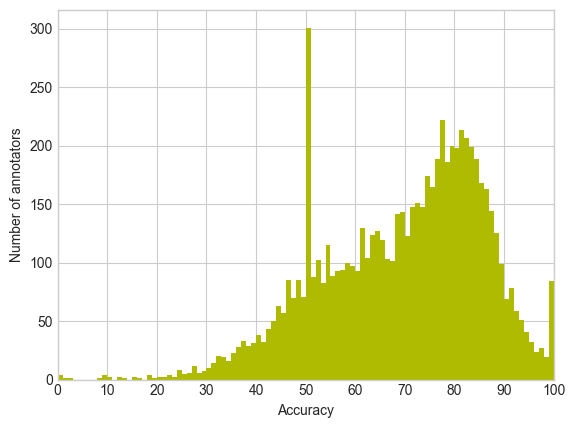

In [18]:
# Histogram of all accuracies
fig = plt.figure()
ax = plt.axes()
ax.hist(accuracies.values(), bins=100, color="#afbb00")
ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0,101,10), minor=False)
ax.set_xlabel("Accuracy")
ax.set_ylabel("Number of annotators")

# plt.savefig("distribution of accuracies", dpi=400, bbox_inches='tight')

## Experiment 1
### How does setting a threshold for the worker's accuracy affect the test score? (Accuracy based on crowdsourced labels.) 

In [22]:
scores = []
mv_scores = []
nr_workers = []
gt_size = []
for threshold in range(0,101):
    good_workers = [item[0] for item in accuracies.items() if item[1] >= threshold]
    nr_workers.append(len(good_workers))
    good_df = df[df['worker'].isin(good_workers)]
    
    good_ds = DawidSkene(n_iter=100)
    good_ds_result = good_ds.fit_predict(good_df)
    gt_good = gt[gt.index.isin(good_ds_result.index)]
    gt_size.append(len(gt_good))
    #score = f1_score(gt_good, good_ds_result[gt_good.index])
    #scores.append(score)
    
    #mv = MajorityVote()
    #mv_result = mv.fit_predict(good_df)
    #mv_score = f1_score(gt_good, mv_result[gt_good.index])
    #mv_scores.append(mv_score)

In [ ]:
fig = plt.figure()
ax = plt.axes()

x = range(0,101)
ax.plot(x, scores, c="#00AFBB", alpha = 0.85, label = "Dawid-Skene")
ax.plot(x, mv_scores, c="#bb6a00", alpha=0.85, label = "Majority Vote")
ax.set_xlim(0, 100)
ax.set_ylim(0.75, 1)
ax.set_xlabel("Accuracy threshold (Dawid-Skene)")
ax.set_ylabel("F1 score (ground truth)")
ax.legend()
# plt.savefig("accuracy threshold", dpi=400, bbox_inches='tight')

Text(0, 0.5, 'Number of annotators')

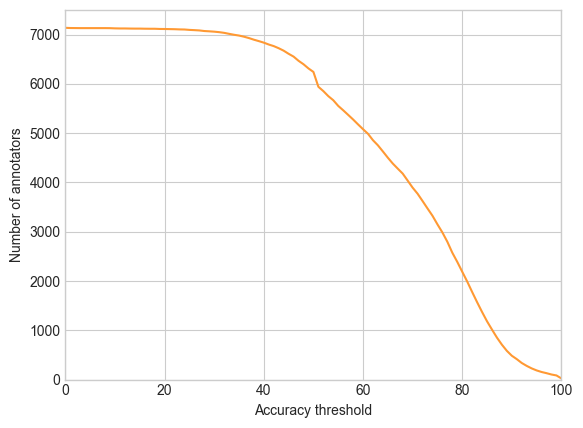

In [19]:
fig = plt.figure()
ax = plt.axes()

x = range(0,101)
ax.plot(x, nr_workers, c="#FF9933")
ax.set_xlim(0, 100)
ax.set_ylim(0, 7500)
ax.set_xlabel("Accuracy threshold")
ax.set_ylabel("Number of annotators")
# plt.savefig("number_annotators", dpi=400, bbox_inches='tight')

Text(0, 0.5, 'Test data size')

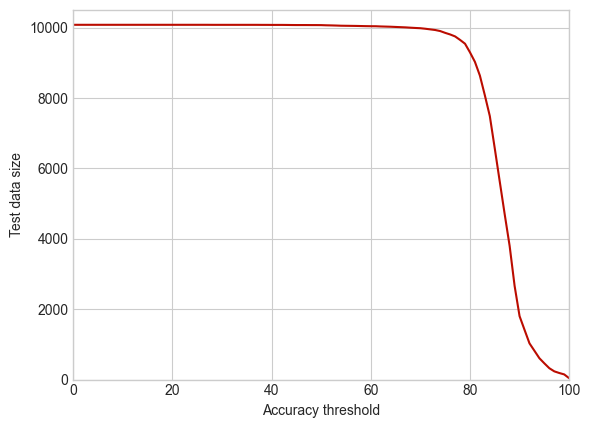

In [26]:
fig = plt.figure()
ax = plt.axes()

x = range(0,101)
ax.plot(x, gt_size, c="#bb0c00")
ax.set_xlim(0, 100)
ax.set_ylim(0, 10500)
ax.set_xlabel("Accuracy threshold")
ax.set_ylabel("Test data size")
# plt.savefig("test data size", dpi=400, bbox_inches='tight')

## Experiment 2
### What if I updated the accuracies every iteration?

#### Before I used the threshold to leave annotators out based on the *original* accuracies.

scores = []
mv_scores = []
nr_workers = []
for threshold in range(0,101):
    good_workers = [item[0] for item in accuracies.items() if item[1] >= threshold]
    nr_workers.append(len(good_workers))
    good_df = df[df['worker'].isin(good_workers)]
    
    good_ds = DawidSkene(n_iter=100)
    good_ds_result = good_ds.fit_predict(good_df)
    gt_good = gt[gt.index.isin(good_ds_result.index)]
    score = f1_score(gt_good, good_ds_result[gt_good.index])
    scores.append(score)
    
    mv = MajorityVote()
    mv_result = mv.fit_predict(good_df)
    mv_score = f1_score(gt_good, mv_result[gt_good.index])
    mv_scores.append(mv_score)
    
    errors_ds = good_ds.errors_
    worker_ids = set([tup[0] for tup in errors_ds.index])
    accuracies = dict.fromkeys(worker_ids, 0)

    for w_id in worker_ids:
        if 0 in errors_ds.loc[w_id][0].keys():
            TN = errors_ds.loc[w_id][0][0]
        else:
            TN = 0
        if 1 in errors_ds.loc[w_id][1].keys():
            TP = errors_ds.loc[w_id][1][1]
        else:
            TP = 0

        accuracy = round((TP + TN) / 2 * 100, 2)
        accuracies[w_id] = accuracy

fig = plt.figure()
ax = plt.axes()

x = range(0,101)
ax.plot(x, scores, c="#00AFBB", alpha = 0.85, label = "Dawid-Skene")
ax.plot(x, mv_scores, c="#bb6a00", alpha=0.85, label = "Majority Vote")
ax.set_xlim(0, 100)
ax.set_ylim(0.75, 1)
ax.set_xlabel("Accuracy threshold (Dawid-Skene)")
ax.set_ylabel("F1 score (ground truth)")
ax.legend()
#### plt.savefig("accuracy threshold with iterations", dpi=400, bbox_inches='tight')

fig = plt.figure()
ax = plt.axes()

x = range(0,101)
ax.plot(x, nr_workers, c="#FF9933")
ax.set_xlim(0, 100)
ax.set_ylim(0, 7500)
ax.set_xlabel("Accuracy threshold")
ax.set_ylabel("Number of annotators")
##### plt.savefig("number of annotators with iterations", dpi=400, bbox_inches='tight')

## Experiment 3
### Fallback: testing on the full GT data, with accuracy threshold, using initial model as fallback

In [54]:
fallback_ds = DawidSkene(n_iter=100)
fallback_ds_result = fallback_ds.fit_predict(df)  # Use the labels from the first model as fallback.

scores_with_fallback = []
for threshold in range(0, 101):
    good_workers = [item[0] for item in accuracies.items() if item[1] >= threshold]
    good_df = df[df['worker'].isin(good_workers)]

    good_ds = DawidSkene(n_iter=100)
    good_ds_result = good_ds.fit_predict(good_df)
    
    # Merge results with fallback labels for instances where no annotators are available
    merged_result = good_ds_result.combine_first(fallback_ds_result)
    
    gt_good = gt[gt.index.isin(merged_result.index)]
    score = f1_score(gt_good, merged_result[gt_good.index])
    scores_with_fallback.append(score)

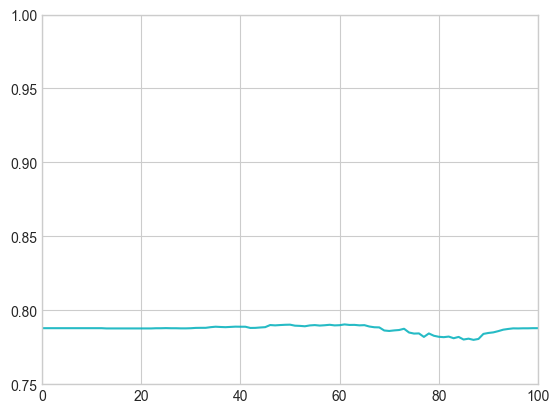

In [55]:
fig = plt.figure()
ax = plt.axes()

x = range(0,101)
ax.plot(x, scores_with_fallback, c="#00AFBB", alpha = 0.85, label = "Dawid-Skene")
ax.set_xlim(0, 100)
ax.set_ylim(0.75, 1)
#ax.set_xlabel("Accuracy threshold (Dawid-Skene)")
#ax.set_ylabel("F1 score (ground truth)")
#ax.legend()
plt.savefig("fallback accuracy threshold", dpi=400, bbox_inches='tight')

## Experiment 4

### Adding more noise
How do the results change if I add more noise to the data? Both models' performance should drop. But does Dawid-Skene now outperform majority voting by a greater margin?

In [ ]:
# TODO